# Gradient Boost Classifier (GBC) as model
*by Max*

In this notebook we will fit our data via GBC models. We start by loading the needed modules and the data.

In [28]:
# import the needed modules
import numpy as np
import pandas as pd
import sys

# import the machine learning modules
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss

# import plotting modules and style
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(context='notebook', style='darkgrid', palette='crest', font='helvetica')
sns.set(rc={"figure.dpi":300})
sns.set(rc = {"figure.figsize":(6,3)})

# import own modules from the scr folder
sys.path.append("../src/")
from train_test_function import train_test_split_fields

# set a random seed
RSEED = 42
np.random.seed(RSEED)

In [3]:
# set the directory of the data
OUTPUT_DIR = "../data"

# load the base data from the CSV files
df = pd.read_csv(f"{OUTPUT_DIR}/mean_band_perField_perDate.csv")
df.head()

,field_id,date,label,B02,B03,B04,B08,B11,B12,CLM
0,1,2017-04-01,4,21.934084,29.180065,35.554660,62.490353,68.39710,46.040190,255.0
1,1,2017-04-11,4,14.844051,23.114147,30.607718,58.736336,73.43569,48.863342,0.0
2,1,2017-04-21,4,13.385852,21.596462,29.223473,57.065918,73.66881,49.313503,0.0
3,1,2017-05-01,4,15.408361,22.471062,29.371382,56.434082,71.05788,46.557877,0.0
4,1,2017-05-11,4,54.829582,65.739550,72.906750,95.672030,66.14791,58.643085,255.0


We need to get rid of the absolute time, therefore we calculate the days from the beginning of the measurements (in april).

In [5]:
# convert the date column to datetime object
df['date'] = pd.to_datetime(df['date'])

# calculate the days from april as column to get a relative time
df['days_from_april_days'] =  df['date'] - pd.to_datetime('2017-04-01')
df['days_from_april_days'] = df['days_from_april_days'].dt.days
df.head()

,field_id,date,label,B02,B03,B04,B08,B11,B12,CLM,days_from_april_days
0,1,2017-04-01,4,21.934084,29.180065,35.554660,62.490353,68.39710,46.040190,255.0,0
1,1,2017-04-11,4,14.844051,23.114147,30.607718,58.736336,73.43569,48.863342,0.0,10
2,1,2017-04-21,4,13.385852,21.596462,29.223473,57.065918,73.66881,49.313503,0.0,20
3,1,2017-05-01,4,15.408361,22.471062,29.371382,56.434082,71.05788,46.557877,0.0,30
4,1,2017-05-11,4,54.829582,65.739550,72.906750,95.672030,66.14791,58.643085,255.0,40


---
## Train-test split, validation split & resampling
Next we do the train-test split and also a validation split.

In [6]:
# do the train-test-split
df_train, df_test = train_test_split_fields(df, train_size=0.7, random_state=RSEED)

# do the validation split
df_train_val, df_test_val = train_test_split_fields(df_train, train_size=0.7, random_state=RSEED)

We setup the the features (X) and the target (y) for the validation train and test data.

In [26]:
# get X for the train and validation data
X_train = df_train_val.drop(columns=['label', 'field_id', 'date', 'CLM'])
X_val = df_test_val.drop(columns=['label', 'field_id', 'date', 'CLM'])

# get y for the train and validation data
y_train = df_train_val['label']
y_train = y_train.astype(int)
y_val = df_test_val['label']
y_val = y_val.astype(int)

# get the length of the X_train before resampling
print(f"Number of observations of X_train before resampling: {len(X_train)}")

Number of observations of X_train before resampling: 2108931


Since we have a high imbalance in the target we need to resample (oversample) the data.

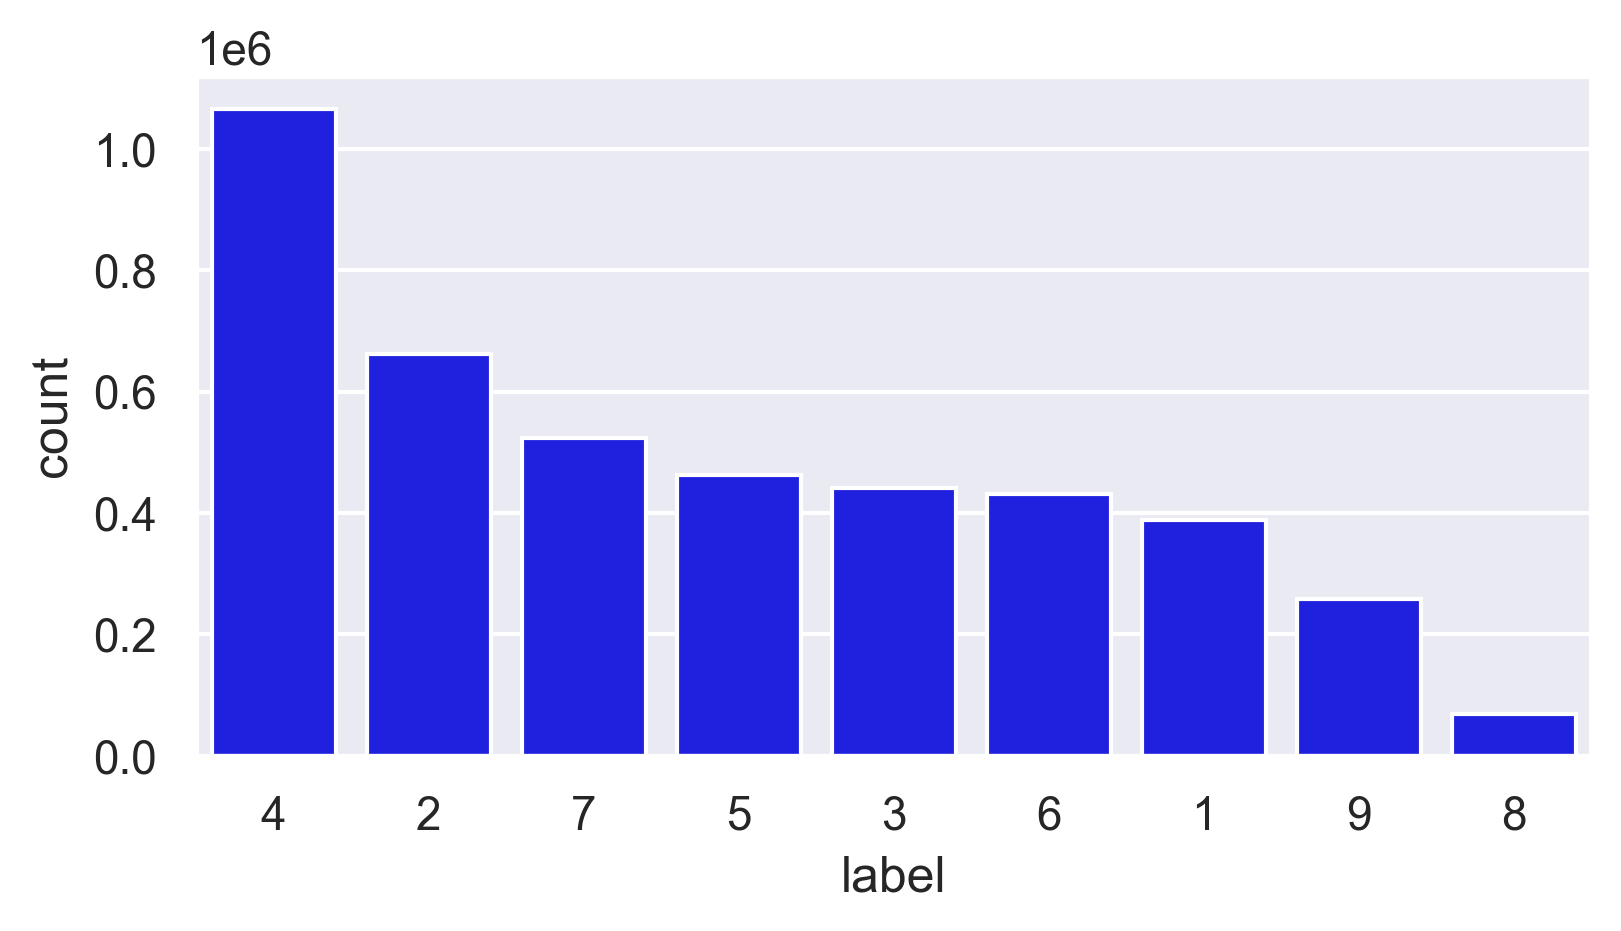

In [35]:
ax = sns.countplot(x="label", data=df, order = df['label'].value_counts().index, color='blue')
plt.title()

In [27]:
# transform the dataset
resample = SMOTE(random_state=RSEED, n_jobs=-1)
X_train, y_train = resample.fit_resample(X_train, y_train)

# get the length of the X_train before resampling
print(f"Number of observations of X_train after resampling: {len(X_train)}")

Number of observations of X_train after resampling: 4705668


---
## Modelling with scikit-learns Gradient Boosting Classifier
We will start this process by using the GradientBoostingClassifier of sklearn with the default hyperparameters.


In [36]:
# initialize a default GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=RSEED)
gbc.fit(X_train, y_train)

In [ ]:
# predict the absolute classes and probabilities 
y_pred_train = gbc.predict(X_train)
y_pred_val = gbc.predict(X_val)

# predict the probabilities for each  class
y_proba_train = gbc.predict_proba(X_train)
y_proba_val = gbc.predict_proba(X_val)

In [ ]:
print('---'*12)
print(f'Accuracy on train data: {round(accuracy_score(y_train, y_pred_train), 3)}')
print(f'Accuracy on test data: {round(accuracy_score(y_val, y_pred_val), 3)}')
print('---'*12)
print(f'F1-score on train data: {round(f1_score(y_train, y_pred_train, average="macro"), 3)}')
print(f'F1-score on test data: {round(f1_score(y_val, y_pred_val, average="macro"), 3)}')
print('---'*12)
print(f'Cross-entropy on train data: {round(log_loss(y_train, y_proba_train), 3)}')
print(f'Cross-entropy on test data: {round(log_loss(y_val, y_proba_val), 3)}')
print('---'*12)

In [ ]:
params = {
    'learning_rate':    [0.01, 0.1, 0.3],
    'n_estimators':     [10, 50, 100],
    'subsample':        [0.5, 1.0],
    
}